<a href="https://colab.research.google.com/github/leobonn1/devai/blob/main/iaam_trabalho3_leonardo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Árvore de decisão para atributos contínuos

Observações:
* Usei a base Wine do scikit-learn
* O único pré-processamento feito foi o scaler, para normalizar as características
* Deixei a implementação ZeroR com uso do método maisFrequente para poder comparar os resultados
* Criei o método melhorValor1 com a alteração sugerida, o método melhorCaracteristica1 que chama melhorValor1 e o classificador Arvore1, que usa  melhorCaracteristica1


In [ ]:
#from sklearn.datasets import load_iris
#dataset = load_iris()
from sklearn.datasets import load_wine
X, y = load_wine(return_X_y=True)

In [131]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [133]:
from sklearn.base import BaseEstimator, ClassifierMixin
from collections import Counter
import numpy as np
from sklearn.model_selection import cross_validate

def maisFrequente(y):
  return Counter(y.flat).most_common(1)[0][0]

class ZeroR(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    y[:] = self.resposta
    return y

scores = cross_validate(ZeroR(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.38888889, 0.38888889, 0.38888889, 0.4       , 0.42857143]),
 0.3990476190476191)

In [160]:
modelo = ZeroR()
modelo.fit(X, y)
modelo.resposta

1

In [161]:
modelo = ZeroR()
modelo.fit(X, y)
ypred = modelo.predict(X)
sum(y==ypred)/len(y)

0.398876404494382

In [136]:
class Arvore(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.caracteristica = 2
    self.valor = np.mean(X[:,self.caracteristica])
    maiores = X[:,self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = Arvore()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = Arvore()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    if hasattr(self, 'resposta'):
      y[:] = self.resposta
    else:
      maiores = X[:,self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

modelo = Arvore()
modelo.fit(X, y)
ypred = modelo.predict(X)
sum(y==ypred)/len(y)

0.702247191011236

In [137]:
scores = cross_validate(Arvore(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.36111111, 0.47222222, 0.5       , 0.4       , 0.28571429]),
 0.4038095238095238)

In [162]:
def impureza(y): #Gini
  labels = list(set(y))
  labels.sort()
  probabilidades = np.zeros((len(labels),))
  for i, k in enumerate(labels):
    probabilidades[i] = sum(y==k)/len(y)
  result = 1 - sum(probabilidades ** 2)
  return result

impureza(y[:])

0.6583133442747129

In [163]:
def impurezaValor(x, y, valor):
  maiores = x > valor
  impurezamaiores = impureza(y[maiores])
  proporcaomaiores = sum(maiores)/len(y)
  impurezamenores = impureza(y[~maiores])
  proporcaomenores = sum(~maiores)/len(y)
  impurezaTotal = proporcaomaiores*impurezamaiores + proporcaomenores*impurezamenores
  return impurezaTotal, impurezamenores, impurezamaiores

impurezaValor(X[:,2], y, 2.5)

(0.6570480081716037, 0.6588326446280992, 0.5)

In [164]:
def melhorValor(x, y):
  result = None
  menorImpureza = float('inf')
  xmax = np.max(x)
  xmin = np.min(x)
  while True:
    valor = (xmin+xmax)/2
    impTotal, impMenores, impMaiores = impurezaValor(x, y, valor)
    if impTotal < menorImpureza:
      menorImpureza = impTotal
      result = valor
      if impMaiores == 0 or impMenores == 0:
        break
      if impMaiores < impMenores:
        xmin = valor
      else:
        xmax = valor
    else:
      break
  return result, menorImpureza

melhorValor(X[:,2], y)

(-0.26141848202328566, 0.6139307817100282)

In [165]:
def melhorCaracteristica(X, y):
  impurezas = []
  valores = []
  for caracteristica in range(X.shape[1]):
    valor, imp = melhorValor(X[:,caracteristica], y)
    impurezas.append(imp)
    valores.append(valor)
  # print(impurezas)
  # print(valores)
  impurezas = np.array(impurezas)
  caracteristica = np.argmin(impurezas)
  return impurezas[caracteristica], caracteristica, valores[caracteristica]

melhorCaracteristica(X, y)

(0.43761750381193476, 12, 0.7391424652275728)

In [166]:
class Arvore(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.impureza, self.caracteristica, self.valor = melhorCaracteristica(X, y)
    #print(f'{self.impureza}, {self.caracteristica}, {self.valor}')
    maiores = X[:,self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = Arvore()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = Arvore()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    if hasattr(self, 'resposta'):
      y[:] = self.resposta
    else:
      maiores = X[:,self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

modelo = Arvore()
modelo.fit(X, y)
ypred = modelo.predict(X)
sum(y==ypred)/len(y)

1.0

In [173]:
def melhorValor1(x, y):
  result = None
  menorImpureza = float('inf')

  # trata caso especial de x com uma linha só
  if x.shape[0] < 2:
    return x[0], 0.0

  x1 = np.sort(x)
  for i in range(y.shape[0] - 1):
    valor = (x1[i]+x1[i+1])/2
    impTotal, impMenores, impMaiores = impurezaValor(x1, y, valor)
    if impTotal < menorImpureza:
      #print(f'valor: {valor}, menor: {menorImpureza}, nova: {impTotal}')
      menorImpureza = impTotal
      result = valor

  return result, menorImpureza

melhorValor1(X[:,2], y)

(-0.35280200480440144, 0.3217826456425267)

In [174]:
def melhorCaracteristica1(X, y):
  impurezas = []
  valores = []
  for caracteristica in range(X.shape[1]):
    valor, imp = melhorValor1(X[:,caracteristica], y)
    impurezas.append(imp)
    valores.append(valor)
  #print(impurezas)
  #print(valores)
  impurezas = np.array(impurezas)
  caracteristica = np.argmin(impurezas)
  return impurezas[caracteristica], caracteristica, valores[caracteristica]

melhorCaracteristica1(X, y)

(0.3217826456425267, 0, -0.6060431988510735)

In [175]:
class Arvore1(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.impureza, self.caracteristica, self.valor = melhorCaracteristica1(X, y)
    #print(f'fit: {X.shape[0]}, {self.impureza}, {self.caracteristica}, {self.valor}')
    maiores = X[:,self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = Arvore1()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = Arvore1()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    if hasattr(self, 'resposta'):
      y[:] = self.resposta
    else:
      maiores = X[:,self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

modelo1 = Arvore1()
modelo1.fit(X, y)
ypred = modelo1.predict(X)
sum(y==ypred)/len(y)

1.0

In [170]:
scores = cross_validate(Arvore(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.77777778, 0.88888889, 0.80555556, 1.        , 0.97142857]),
 0.8887301587301588)

In [176]:
scores = cross_validate(Arvore1(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.66666667, 0.66666667, 0.77777778, 0.8       , 0.71428571]),
 0.7250793650793652)

A média de Scores ficou assim:
- ZeroR (predição com maisFrequente): 0.4038095238095238
- Arvore (melhorValor usando mean): 0.8887301587301588
- Arvore1: (melhorValor alterado) 0.7250793650793652

Portanto, a alteração piorou o resultado em relação à Arvore, apesar de ter melhorado em relação à Arvore com maisFrequente

In [179]:
import timeit
modelo = Arvore()
result = timeit.timeit(stmt='modelo.fit(X,y)', globals=globals(), number=10)
print(f'Tempo do fit (Arvore): {result}')

Tempo do fit (Arvore): 1.9875661739988573


In [181]:
import timeit
modelo1 = Arvore1()
result = timeit.timeit(stmt='modelo1.fit(X,y)', globals=globals(), number=10)
print(f'Tempo do fit (Arvore1): {result}')

Tempo do fit (Arvore1): 23.297404504999577


Comparação:
* Tempo do fit (Arvore): 1.9612915109992173
* Tempo do fit (Arvore1): 19.237037956001586
Portanto, o tempo de execução piorou bastante em relação ao método original


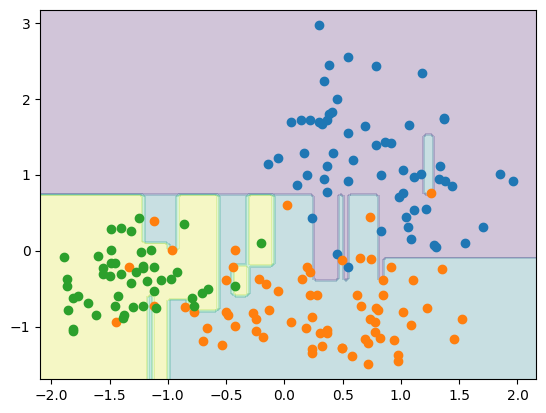

In [182]:
import matplotlib.pyplot as plt

def plotDecisao(modelo, X, y):
  modelo.fit(X, y)
  x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
  x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
  x0, x1 = np.meshgrid(x0s, x1s)
  Xdec = np.c_[x0.ravel(), x1.ravel()]
  ypred = modelo.predict(Xdec)
  plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
  for k in set(y):
    plt.plot(X[:,0][y==k], X[:,1][y==k], 'o')
  plt.show()

plotDecisao(Arvore(), X[:,11:13], y)

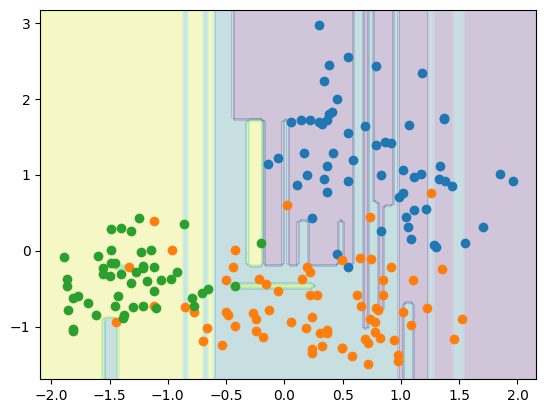

In [183]:
plotDecisao(Arvore1(), X[:,11:13], y)